In [1]:
import xgboost as xgb 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
import optuna

from scipy.stats import spearmanr
from utils.common import day_aware_shift
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, make_scorer, matthews_corrcoef
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from multiprocessing import Pool
from functools import partial
from itertools import product

In [2]:
def target_pipeline(df, feature='z_close_30m', shift=5, threshold=0.5):
    def get_trend(x):
        if x > threshold:
            return 'up'
        elif x < -threshold:
            return 'down'
        else:
            return 'neutral'
    df['target'] = df[feature].apply(get_trend)
    if 'datetime' not in df.columns:
        df['datetime'] = df.index
    df = day_aware_shift(df, 'target', -shift)
    df = df.drop(labels='datetime', axis=1)

    return df

In [3]:
class TimeSeriesCV:
    def __init__(self, train_length=24, val_length=8):
        # train on ~6 months, predict 2
        # ~6 months = 4 * 6 = 24 days
        # ~2 months = 4 * 2 = 8 days

        self.train_length = train_length
        self.val_length = val_length

    def split(self, X, y=None, groups=None):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', UserWarning)
            unique_dates = X.index.to_period('D').unique()
        days = sorted(unique_dates, reverse=False)
        n_days = len(days)

        for idx in range(n_days-self.val_length-self.train_length+1):
            train_days = days[idx:(idx+self.train_length)]
            val_days = days[(idx+self.train_length):(idx+self.train_length+self.val_length)]

            with warnings.catch_warnings():
                warnings.simplefilter('ignore', UserWarning)
                train_idx = X[X.index.to_period('D').isin(train_days)].index
                val_idx = X[X.index.to_period('D').isin(val_days)].index

            yield train_idx.to_numpy(), val_idx.to_numpy()

    def get_n_splits(self, X,  y, groups=None):
        return 73


In [4]:
with pd.HDFStore('./large_files/data.h5', mode='r') as store:
    df = store.get('feature_engineering/20240201')
df.info(verbose=3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579355 entries, 525 to 92654
Data columns (total 159 columns):
 #    Column               Dtype                           
---   ------               -----                           
 0    date                 object                          
 1    time                 object                          
 2    open                 float64                         
 3    high                 float64                         
 4    low                  float64                         
 5    close                float64                         
 6    volume               int64                           
 7    datetime             datetime64[ns, America/New_York]
 8    day                  object                          
 9    month                int64                           
 10   bb_high              float64                         
 11   bb_low               float64                         
 12   dollar_vol           float64            

In [5]:
to_drop = [c for c in df.columns if 'sma' in c] + [c for c in df.columns if 'std' in c] + \
    ['date', 'time', 'open', 'high', 'low', 'close', 'volume', 'day', 'dollar_vol']

cat_cols = ['month', 'rsi_5_signal', 'rsi_15_signal', 'rsi_30_signal', 'rsi_60_signal']

# convert month to categorical, rsi signal is already categorical
df['month'] = pd.Categorical(df['month'])

In [6]:
df2 = df.set_index('datetime', drop=True)
df2 = df2[df2.index.dayofweek == 2]
df2 = df2.drop(to_drop, axis=1)

df2.info(show_counts=True, verbose=3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523176 entries, 2007-04-04 07:00:00-04:00 to 2024-01-24 09:34:00-05:00
Data columns (total 125 columns):
 #    Column               Non-Null Count   Dtype   
---   ------               --------------   -----   
 0    month                523176 non-null  category
 1    bb_high              497830 non-null  float64 
 2    bb_low               497830 non-null  float64 
 3    z_close_5m           518484 non-null  float64 
 4    pct_close_5m         519680 non-null  float64 
 5    z_volume_5m          519655 non-null  float64 
 6    pct_volume_5m        519680 non-null  float64 
 7    z_dollar_vol_5m      519680 non-null  float64 
 8    pct_dollar_vol_5m    519680 non-null  float64 
 9    z_close_15m          510939 non-null  float64 
 10   pct_close_15m        510940 non-null  float64 
 11   z_volume_15m         510940 non-null  float64 
 12   pct_volume_15m       510940 non-null  float64 
 13   z_dollar_vol_15m     510940 non-null  flo

In [7]:
df_train = df2.loc[df2.index.year.isin([2021, 2022])]
cv = TimeSeriesCV()
for i, (train_idx, test_idx) in enumerate(cv.split(X=df_train)):
    train_dates = df_train.loc[train_idx].index.unique()
    test_dates = df_train.loc[test_idx].index.unique()
    print(f'Train Start: {train_dates.min()} Train End: {train_dates.max()} Val Start: {test_dates.min()} Val End: {test_dates.max()}')

Train Start: 2021-01-06 07:00:00-05:00 Train End: 2021-06-16 16:59:00-04:00 Val Start: 2021-06-23 07:00:00-04:00 Val End: 2021-08-11 16:59:00-04:00
Train Start: 2021-01-13 07:00:00-05:00 Train End: 2021-06-23 16:59:00-04:00 Val Start: 2021-06-30 07:00:00-04:00 Val End: 2021-08-18 16:59:00-04:00
Train Start: 2021-01-20 07:00:00-05:00 Train End: 2021-06-30 16:59:00-04:00 Val Start: 2021-07-07 07:00:00-04:00 Val End: 2021-08-25 16:59:00-04:00
Train Start: 2021-01-27 07:00:00-05:00 Train End: 2021-07-07 16:59:00-04:00 Val Start: 2021-07-14 07:00:00-04:00 Val End: 2021-09-01 16:59:00-04:00
Train Start: 2021-02-03 07:00:00-05:00 Train End: 2021-07-14 16:59:00-04:00 Val Start: 2021-07-21 07:00:00-04:00 Val End: 2021-09-08 16:59:00-04:00
Train Start: 2021-02-10 07:00:00-05:00 Train End: 2021-07-21 16:59:00-04:00 Val Start: 2021-07-28 07:00:00-04:00 Val End: 2021-09-15 16:59:00-04:00
Train Start: 2021-02-17 07:00:00-05:00 Train End: 2021-07-28 16:59:00-04:00 Val Start: 2021-08-04 07:00:00-04:00

- Identify how long ahead should we predict
- Threshold of signal
- What target to use

In [17]:
df_train = df2.loc[df2.index.year.isin([2021, 2022])]
cv = TimeSeriesCV()

lookaheads = [5, 10, 15, 30]
thresholds = [0.5, 1.0]
targets = ['z_close_30m', 'z_close_15m', 'z_close_5m']

base_params = {
    'objective': 'multi:softmax',
    'random_state': 42,
    'learning_rate': 0.05,
    'nthread': -1,
    'max_depth': 5,
    'early_stopping_rounds': 10,
    'tree_method': 'hist',
    'enable_categorical': True,
    'num_class': 3,
    'device': 'cuda'
}

df_fold = []
df_pred = []
df_importance = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X=df_train)):
    train_dates = df_train.loc[train_idx].index.unique()
    val_dates = df_train.loc[val_idx].index.unique()

    train_set = df_train.loc[train_dates]
    val_set = df_train.loc[val_dates]

    df_fold_result = []
    for lookahead in lookaheads:
        for threshold in thresholds:
            for target in targets:
                train_set = target_pipeline(train_set, target, lookahead, threshold)
                val_set = target_pipeline(val_set, target, lookahead, threshold)

                train_set = train_set[(train_set.index.hour >= 9) & (train_set.index.hour < 16)]
                val_set = val_set[(val_set.index.hour >= 9) & (val_set.index.hour < 16)]

                train_set = train_set.dropna(axis=0)
                val_set = val_set.dropna(axis=0)

                Xtr, ytr = train_set.drop('target', axis=1), train_set['target']
                Xvl, yvl = val_set.drop('target', axis=1), val_set['target']

                le = LabelEncoder()
                ytr = le.fit_transform(ytr)
                yvl = le.transform(yvl)

                model = xgb.XGBClassifier(**base_params)
                model.fit(
                    Xtr, 
                    ytr, 
                    eval_set=[(Xtr, ytr), (Xvl, yvl)], 
                    verbose=False
                )

                calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
                calibrated_model.fit(Xtr, ytr)
                ytr_pred = calibrated_model.predict(Xtr)
                y_pred = calibrated_model.predict(Xvl)

                val_set2 = val_set.copy()
                val_set2['fold'] = fold
                val_set2['lookahead'] = lookahead
                val_set2['threshold'] = threshold
                val_set2['pred_target'] = target
                val_set2['pred'] = y_pred
                df_pred.append(val_set2)
                
                fi = pd.Series(calibrated_model.estimator.feature_importances_, index=calibrated_model.feature_names_in_)
                fi['fold'] = fold
                fi['lookahead'] = lookahead
                fi['threshold'] = threshold
                fi['target'] = target
                
                df_importance.append(fi.to_dict())

                df_fold_result.append({
                    'fold': fold,
                    'lookahead': lookahead,
                    'threshold': threshold,
                    'target': target,
                    'accuracy': accuracy_score(yvl, y_pred),
                    'precision': precision_score(yvl, y_pred, average="weighted"),
                    'recall': recall_score(yvl, y_pred, average="weighted"),
                    'f1': f1_score(yvl, y_pred, average="weighted"),
                    'mcc': matthews_corrcoef(yvl, y_pred),
                    'mcc_train': matthews_corrcoef(ytr, ytr_pred)
                })

                print(f'{fold}  Lookahead: {lookahead}  Threshold: {threshold}  Target: {target}')

    df_fold_result = pd.DataFrame(df_fold_result).sort_values(['lookahead', 'threshold'])
    df_fold.append(df_fold_result)

0  Lookahead: 5  Threshold: 0.5  Target: z_close_30m
0  Lookahead: 5  Threshold: 0.5  Target: z_close_15m
0  Lookahead: 5  Threshold: 0.5  Target: z_close_5m
0  Lookahead: 5  Threshold: 1.0  Target: z_close_30m
0  Lookahead: 5  Threshold: 1.0  Target: z_close_15m
0  Lookahead: 5  Threshold: 1.0  Target: z_close_5m
0  Lookahead: 10  Threshold: 0.5  Target: z_close_30m
0  Lookahead: 10  Threshold: 0.5  Target: z_close_15m
0  Lookahead: 10  Threshold: 0.5  Target: z_close_5m
0  Lookahead: 10  Threshold: 1.0  Target: z_close_30m
0  Lookahead: 10  Threshold: 1.0  Target: z_close_15m
0  Lookahead: 10  Threshold: 1.0  Target: z_close_5m
0  Lookahead: 15  Threshold: 0.5  Target: z_close_30m
0  Lookahead: 15  Threshold: 0.5  Target: z_close_15m
0  Lookahead: 15  Threshold: 0.5  Target: z_close_5m
0  Lookahead: 15  Threshold: 1.0  Target: z_close_30m
0  Lookahead: 15  Threshold: 1.0  Target: z_close_15m
0  Lookahead: 15  Threshold: 1.0  Target: z_close_5m
0  Lookahead: 30  Threshold: 0.5  Target

In [18]:
with pd.HDFStore('./large_files/training.h5') as store:
    store.put('xgb_cv/20240204/prediction', pd.concat(df_pred), format='table')
    store.put('xgb_cv/20240204/feature_importance', pd.DataFrame(df_importance), format='table')
    store.put('xgb_cv/20240204/fold', pd.concat(df_fold, ignore_index=True), format='table')

/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '20240204'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [19]:
with pd.HDFStore('./large_files/training.h5', mode='r') as store:
    df_pred = store.get('xgb_cv/20240204/prediction')
    df_importance = store.get('xgb_cv/20240204/feature_importance')
    df_fold = store.get('xgb_cv/20240204/fold')

In [20]:
df_fold['fold'] = df_fold['fold'].astype(str)
df_fold.groupby(['lookahead', 'threshold', 'target']).mean(numeric_only=True).reset_index()

,lookahead,threshold,target,accuracy,precision,recall,f1,mcc,mcc_train
0,5,0.5,z_close_15m,0.506698,0.485557,0.506698,0.488793,0.228494,0.467698
1,5,0.5,z_close_30m,0.617731,0.596274,0.617731,0.600813,0.404078,0.578190
2,5,0.5,z_close_5m,0.361384,0.347816,0.361384,0.346651,0.002762,0.385039
3,5,1.0,z_close_15m,0.466423,0.462607,0.466423,0.460538,0.139801,0.493877
4,5,1.0,z_close_30m,0.567009,0.569737,0.567009,0.565405,0.311003,0.558610
5,5,1.0,z_close_5m,0.429798,0.398914,0.429798,0.407061,-0.002931,0.481716
6,10,0.5,z_close_15m,0.388045,0.379734,0.388045,0.375154,0.042076,0.407747
7,10,0.5,z_close_30m,0.509860,0.484319,0.509860,0.487826,0.228134,0.511296
8,10,0.5,z_close_5m,0.360038,0.345689,0.360038,0.346634,0.000652,0.404439
9,10,1.0,z_close_15m,0.412200,0.397350,0.412200,0.398761,0.042219,0.446733


In [22]:
df_fold.groupby(['lookahead', 'threshold', 'target']).mean(numeric_only=True).reset_index().sort_values('mcc', ascending=False).head(10)

,lookahead,threshold,target,accuracy,precision,recall,f1,mcc,mcc_train
1,5,0.5,z_close_30m,0.617731,0.596274,0.617731,0.600813,0.404078,0.578190
4,5,1.0,z_close_30m,0.567009,0.569737,0.567009,0.565405,0.311003,0.558610
0,5,0.5,z_close_15m,0.506698,0.485557,0.506698,0.488793,0.228494,0.467698
7,10,0.5,z_close_30m,0.509860,0.484319,0.509860,0.487826,0.228134,0.511296
3,5,1.0,z_close_15m,0.466423,0.462607,0.466423,0.460538,0.139801,0.493877
10,10,1.0,z_close_30m,0.454751,0.455756,0.454751,0.451326,0.139002,0.548441
13,15,0.5,z_close_30m,0.435015,0.415313,0.435015,0.414369,0.107776,0.478763
16,15,1.0,z_close_30m,0.406190,0.412689,0.406190,0.402615,0.074064,0.540640
9,10,1.0,z_close_15m,0.412200,0.397350,0.412200,0.398761,0.042219,0.446733
6,10,0.5,z_close_15m,0.388045,0.379734,0.388045,0.375154,0.042076,0.407747


In [24]:
df_importance['fold'] = df_importance['fold'].astype(str)
df_importance.groupby(['lookahead', 'threshold', 'target']).mean(numeric_only=True).reset_index()

,lookahead,threshold,target,month,bb_high,bb_low,z_close_5m,pct_close_5m,z_volume_5m,pct_volume_5m,...,lag60m_z_close_60m,lag60m_z_volume_60m,lag60m_dst_high_60m,lag60m_dst_low_60m,ma_ratio_5_15,ma_ratio_5_30,ma_ratio_5_60,ma_ratio_15_30,ma_ratio_15_60,ma_ratio_30_60
0,5.0,0.5,z_close_15m,0.008116,0.007331,0.006626,0.006631,0.010404,0.005168,0.006641,...,0.007619,0.006352,0.007567,0.007851,0.008303,0.008219,0.008207,0.008852,0.008072,0.008075
1,5.0,0.5,z_close_30m,0.006609,0.009984,0.008270,0.003599,0.004905,0.003471,0.003809,...,0.005650,0.004452,0.006303,0.006269,0.006643,0.009257,0.006488,0.007628,0.006554,0.006259
2,5.0,0.5,z_close_5m,0.009839,0.006698,0.007599,0.006656,0.007453,0.006234,0.007007,...,0.009513,0.008101,0.009362,0.009910,0.008853,0.010307,0.011080,0.009451,0.010618,0.010186
3,5.0,1.0,z_close_15m,0.008531,0.006557,0.006744,0.014209,0.011749,0.005536,0.007537,...,0.007415,0.006261,0.007494,0.008235,0.012933,0.008603,0.008838,0.008411,0.008626,0.008419
4,5.0,1.0,z_close_30m,0.006840,0.012028,0.013136,0.003892,0.005025,0.003390,0.003864,...,0.006079,0.004595,0.006097,0.006717,0.005786,0.007161,0.006540,0.007704,0.007097,0.006824
5,5.0,1.0,z_close_5m,0.008955,0.007177,0.007004,0.007064,0.007659,0.006806,0.007776,...,0.008716,0.008372,0.009140,0.009039,0.008956,0.009000,0.009289,0.009341,0.009846,0.009512
6,10.0,0.5,z_close_15m,0.010971,0.007325,0.007435,0.013963,0.029365,0.004528,0.005456,...,0.008755,0.007532,0.009884,0.011080,0.008819,0.009481,0.010958,0.011440,0.011707,0.010963
7,10.0,0.5,z_close_30m,0.008513,0.007586,0.008376,0.003694,0.004775,0.003327,0.003803,...,0.007091,0.005905,0.007610,0.007813,0.014349,0.009090,0.007710,0.008411,0.008660,0.008158
8,10.0,0.5,z_close_5m,0.009491,0.006899,0.006792,0.006370,0.007304,0.006468,0.007324,...,0.009104,0.007900,0.009318,0.009716,0.009589,0.009253,0.011071,0.009969,0.010542,0.010511
9,10.0,1.0,z_close_15m,0.010417,0.007082,0.007419,0.006963,0.018185,0.004833,0.005681,...,0.008620,0.007207,0.009174,0.010154,0.009189,0.010125,0.010705,0.010815,0.011206,0.010893


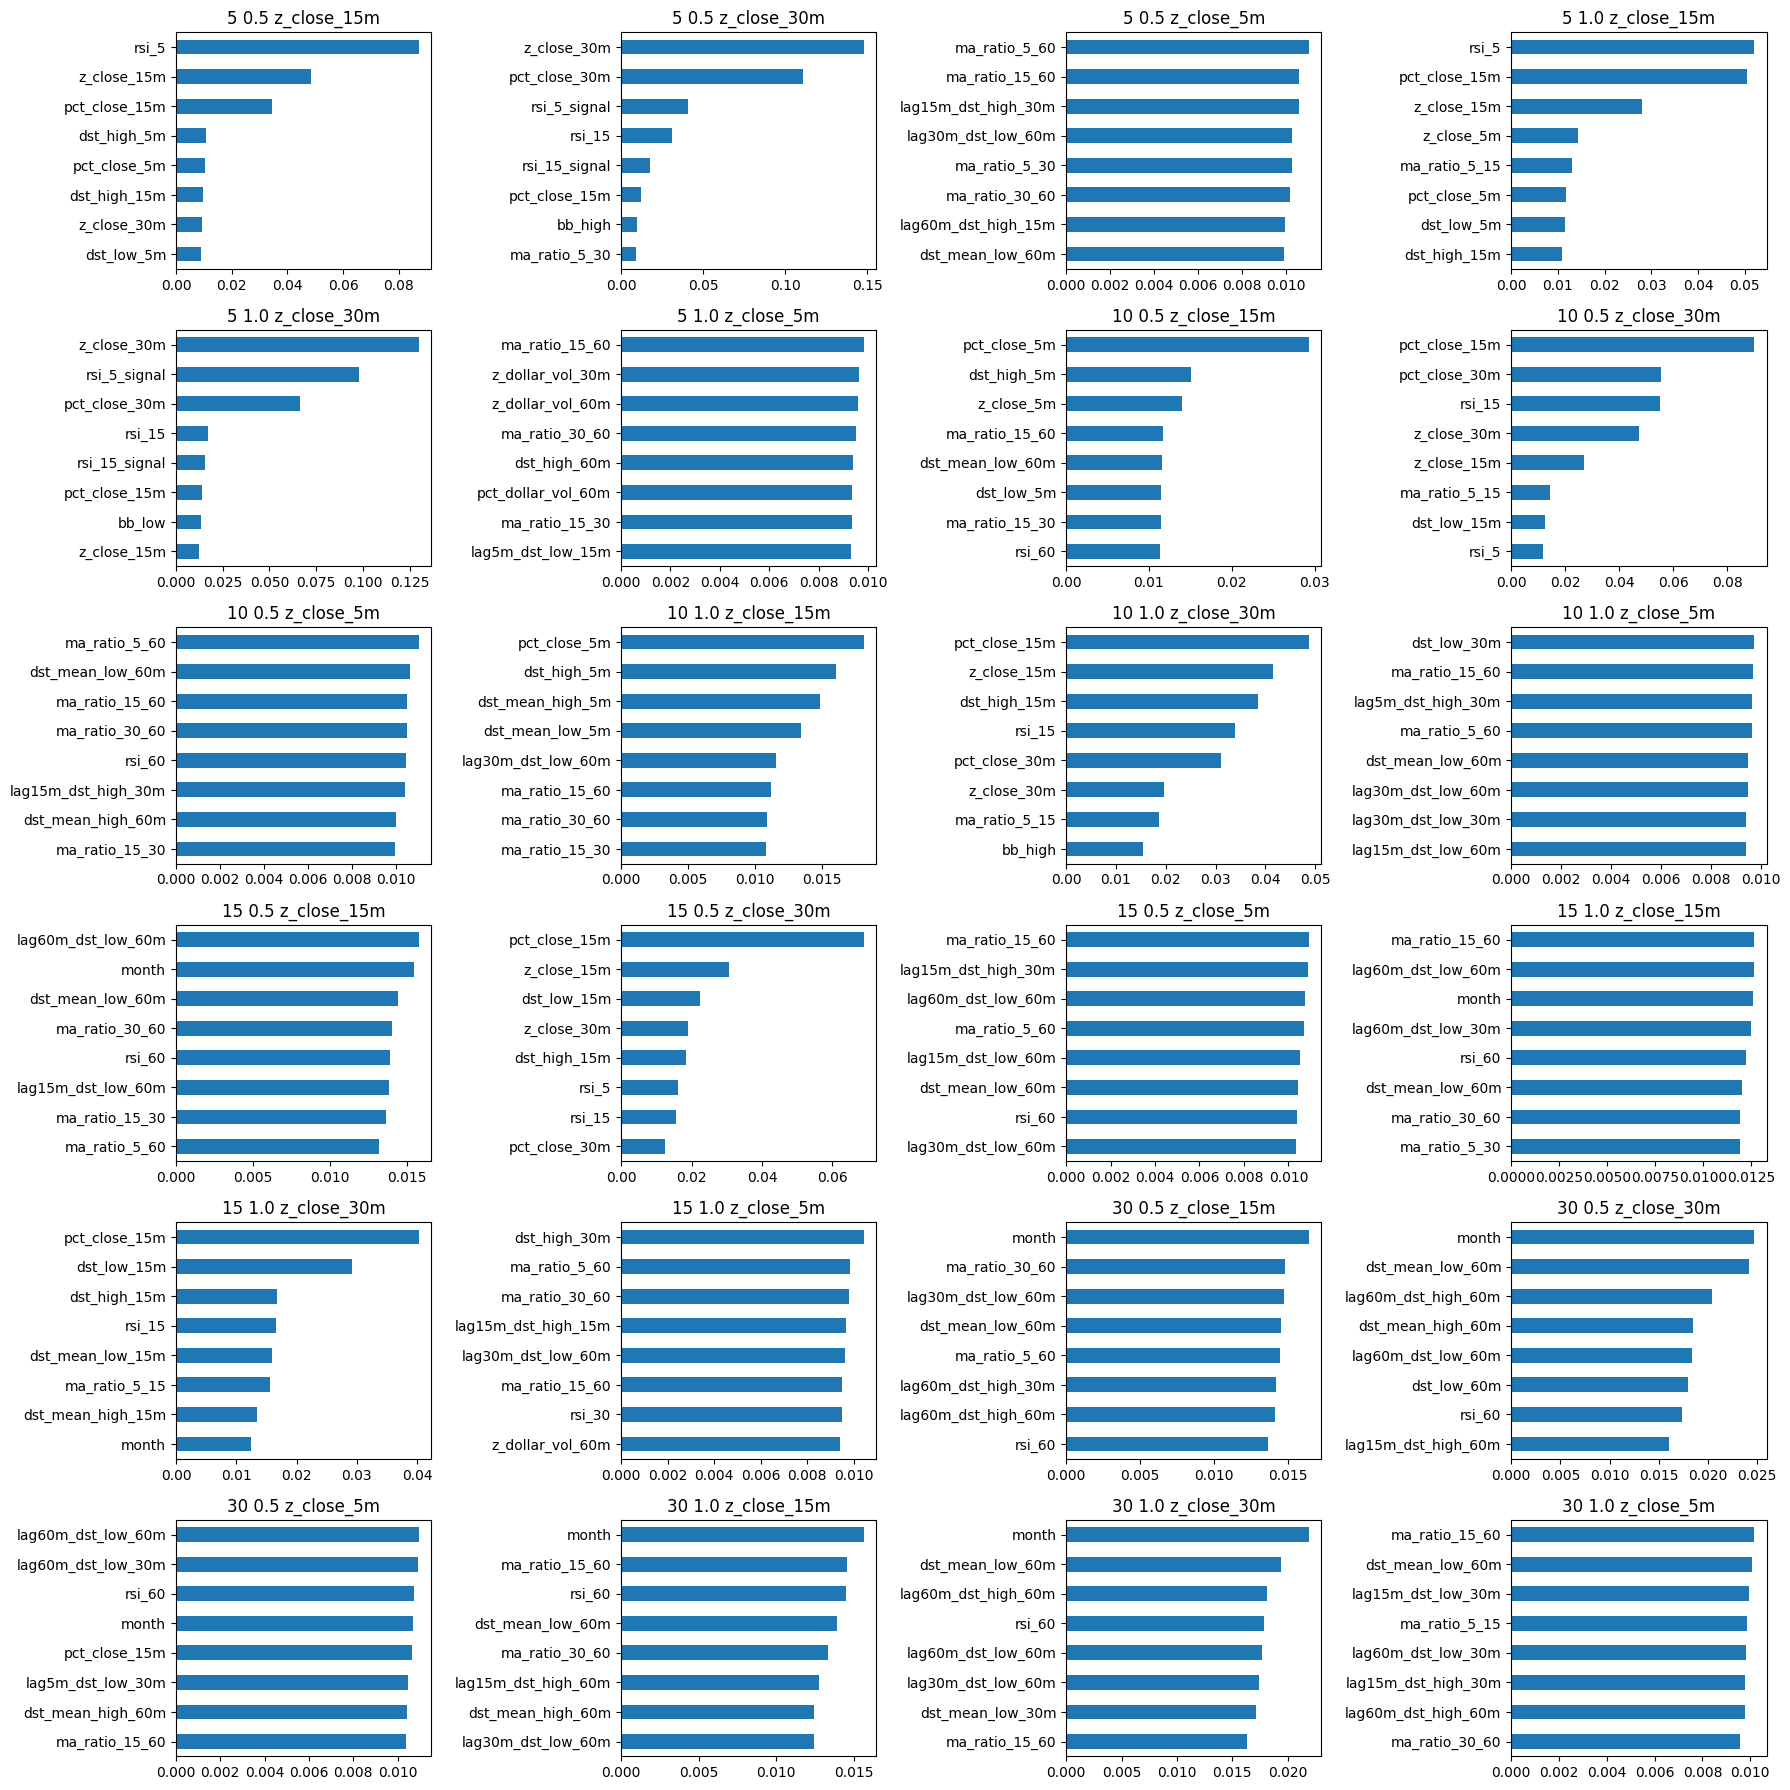

In [25]:
fig, axs = plt.subplots(6, 4, figsize=(18, 18))

for idx, row in df_importance.groupby(['lookahead', 'threshold', 'target']).mean(numeric_only=True).reset_index().iterrows():
    lookahead = row['lookahead']
    threshold = row['threshold']
    target = row['target']

    row = row.drop(['lookahead', 'threshold', 'target']).sort_values(ascending=True)[-8:]
    ax = axs[idx//4, idx%4]
    ax.set_title(f'{int(lookahead)} {threshold} {target}')
    row.plot.barh(ax=ax)

plt.tight_layout()
plt.show()

# Hyperparameter search

In [17]:
target = 'z_close_30m'
threshold = 0.5
lookahead = 5

df_cv = []
for fold, (train_idx, val_idx) in enumerate(cv.split(X=df_train)):
    train_dates = df_train.loc[train_idx].index.unique()
    val_dates = df_train.loc[val_idx].index.unique()

    train_set = df_train.loc[train_dates]
    val_set = df_train.loc[val_dates]

    df_fold_result = []
  
    train_set = target_pipeline(train_set, target, lookahead, threshold)
    val_set = target_pipeline(val_set, target, lookahead, threshold)

    train_set = train_set[(train_set.index.hour >= 9) & (train_set.index.hour < 16)]
    val_set = val_set[(val_set.index.hour >= 9) & (val_set.index.hour < 16)]

    train_set = train_set.dropna(axis=0)
    val_set = val_set.dropna(axis=0)

    Xtr, ytr = train_set.drop('target', axis=1), train_set['target']
    Xvl, yvl = val_set.drop('target', axis=1), val_set['target']

    le = LabelEncoder()
    ytr = le.fit_transform(ytr)
    yvl = le.transform(yvl)

    def objective(trial):
        params = {
            'objective': 'multi:softmax',
            'n_estimators': 1000,
            'verbosity': 0,
            'nthread': -1,
            'enable_categorical': True,
            'device': 'cuda',
            'num_class': 3,
            # 'early_stopping_rounds': 10,
            'tree_method': 'hist',
            'random_state': 42,
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.05, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        }
    
        model = xgb.XGBClassifier(**params)
        model.fit(Xtr, ytr, verbose=False)
        yvl_pred = model.predict(Xvl)
        mcc = matthews_corrcoef(yvl, yvl_pred)

        return mcc
    
    study = optuna.create_study(direction='maximize', study_name=f'fold {fold}')
    study.optimize(objective, n_trials=30, n_jobs=15)

    results = study.best_params
    results['mcc'] = study.best_value
    results['fold'] = fold

    df_cv.append(results)

[I 2024-02-04 01:00:37,951] A new study created in memory with name: fold 0
[I 2024-02-04 01:01:41,289] Trial 1 finished with value: 0.42706134550472596 and parameters: {'learning_rate': 0.05760930560949543, 'max_depth': 1, 'subsample': 0.10929212937437693, 'colsample_bytree': 0.35260810424722294, 'min_child_weight': 12}. Best is trial 1 with value: 0.42706134550472596.
[I 2024-02-04 01:01:41,360] Trial 6 finished with value: 0.42609427406681627 and parameters: {'learning_rate': 0.09435654989521251, 'max_depth': 1, 'subsample': 0.27082211230907133, 'colsample_bytree': 0.6316522151120737, 'min_child_weight': 4}. Best is trial 1 with value: 0.42706134550472596.
[I 2024-02-04 01:02:11,684] Trial 13 finished with value: 0.44010270770944127 and parameters: {'learning_rate': 0.014523360739221631, 'max_depth': 2, 'subsample': 0.9847112090176612, 'colsample_bytree': 0.7141957885465056, 'min_child_weight': 14}. Best is trial 13 with value: 0.44010270770944127.
[I 2024-02-04 01:02:41,219] Trial 

KeyboardInterrupt: 

# Looking at 2021 / 2022 predictions

In [26]:
df_pred['target'] = le.transform(df_pred['target'])
df_pred.head()

,month,bb_high,bb_low,z_close_5m,pct_close_5m,z_volume_5m,pct_volume_5m,z_dollar_vol_5m,pct_dollar_vol_5m,z_close_15m,...,ma_ratio_5_60,ma_ratio_15_30,ma_ratio_15_60,ma_ratio_30_60,target,fold,lookahead,threshold,pred_target,pred
datetime,,,,,,,,,,,,,,,,,,,,,
2021-06-23 09:00:00-04:00,6,0.000416,-0.001446,0.447214,0.000082,1.725830,1.714617,1.725852,1.714736,1.074041,...,1.000441,1.000123,1.000132,1.000009,2,0,5,0.5,z_close_30m,2
2021-06-23 09:01:00-04:00,6,0.000678,-0.001171,-1.043498,-0.000191,0.820197,0.600000,0.819838,0.599737,0.237171,...,1.000434,1.000164,1.000161,0.999998,1,0,5,0.5,z_close_30m,2
2021-06-23 09:02:00-04:00,6,0.000795,-0.001034,-1.338877,-0.000300,-0.374553,-0.264706,-0.374829,-0.264910,-0.299572,...,1.000409,1.000209,1.000200,0.999991,2,0,5,0.5,z_close_30m,0
2021-06-23 09:03:00-04:00,6,0.000634,-0.001163,-0.447214,-0.000082,-0.480951,-0.314961,-0.480984,-0.315026,0.033655,...,1.000325,1.000254,1.000234,0.999980,2,0,5,0.5,z_close_30m,2
2021-06-23 09:04:00-04:00,6,0.000674,-0.000985,-0.816497,-0.000136,-1.082270,-0.674419,-1.082134,-0.674486,-0.672735,...,1.000238,1.000309,1.000257,0.999948,2,0,5,0.5,z_close_30m,2


In [27]:
le.classes_

array(['down', 'neutral', 'up'], dtype=object)

In [28]:
periods = {
    0: ('09:00:00', '09:59:59'),
    1: ('10:00:00', '11:59:59'),
    2: ('12:00:00', '13:59:59'),
    3: ('14:00:00', '15:59:59')
}

df_result_period = []
for day, df_day in df_pred.groupby(pd.Grouper(level='datetime', freq='D')):
    if df_day.shape[0] == 0:
        continue
    
    for fold in df_day['fold'].unique():
        df_day2 = df_day[(df_day['fold'] == fold) & (df_day['pred_target'] == 'z_close_30m') & (df_day['lookahead'] == 5)]
        
        # divide day into 4 segments
        # 0900 0959, 1000 1159, 1200 1359, 1400 1559
        for period_id, period in periods.items():
            df_period = df_day2.between_time(period[0], period[1])
            if df_day2.shape[0] == 0:
                continue
            result = {
                'day': df_day2.index[0].date(),
                'period': period_id,
                'fold': fold,
                'accuracy': accuracy_score(df_period['target'], df_period['pred']),
                'precision': precision_score(df_period['target'], df_period['pred'], average='weighted'),
                'recall': recall_score(df_period['target'], df_period['pred'], average='weighted', zero_division=0.0),
                'f1': f1_score(df_period['target'], df_period['pred'], average='weighted'),
                'mcc': matthews_corrcoef(df_period['target'], df_period['pred'])
            }
            df_result_period.append(result)

df_result_period = pd.DataFrame(df_result_period)

/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
df_result_period.drop('fold', axis=1).groupby(['period']).mean(numeric_only=True).reset_index()

,period,accuracy,precision,recall,f1,mcc
0,0,0.582415,0.607233,0.582415,0.587169,0.301417
1,1,0.602130,0.619293,0.602130,0.605612,0.369372
2,2,0.588857,0.607204,0.588857,0.591081,0.344529
3,3,0.592694,0.612267,0.592694,0.594165,0.354241


In [30]:
df_result_period2 = df_result_period.copy()
df_result_period2 = df_result_period2[pd.to_datetime(df_result_period['day']).dt.year == 2022]
df_result_period2['month'] = pd.to_datetime(df_result_period2['day']).dt.month
df_result_period2.drop('fold', axis=1).groupby(['month']).mean(numeric_only=True)

,period,accuracy,precision,recall,f1,mcc
month,,,,,,
1,1.5,0.579703,0.600786,0.579703,0.584773,0.322089
2,1.5,0.622823,0.646247,0.622823,0.629200,0.378136
3,1.5,0.578021,0.602616,0.578021,0.581323,0.301107
4,1.5,0.606276,0.625126,0.606276,0.610085,0.376606
5,1.5,0.552700,0.572264,0.552700,0.556543,0.290659
6,1.5,0.616913,0.639325,0.616913,0.623380,0.375555
7,1.5,0.594178,0.610128,0.594178,0.597484,0.364112
8,1.5,0.600732,0.627932,0.600732,0.608190,0.322726
9,1.5,0.619193,0.647152,0.619193,0.627977,0.350899
